In [1]:
import pandas as pd

df = pd.read_csv("dataset-modified.csv", index_col=0)
train_df = pd.read_csv("train.csv", index_col=0)
test_df = pd.read_csv("test.csv", index_col=0)
validation_df = pd.read_csv("validation.csv", index_col=0)

# full dataset
X = df.drop("Class", axis=1)
y = df["Class"]  # two classes in the dataset: Kecimen and Besni

X_train = pd.concat(
    [train_df.drop("Class", axis=1), validation_df.drop("Class", axis=1)]
)
y_train = pd.concat([train_df["Class"], validation_df["Class"]])

X_test = test_df.drop("Class", axis=1)
y_test = test_df["Class"]

The optimal number of neighbors is: 12
The optimal number of neighbors based on AUC is: 27


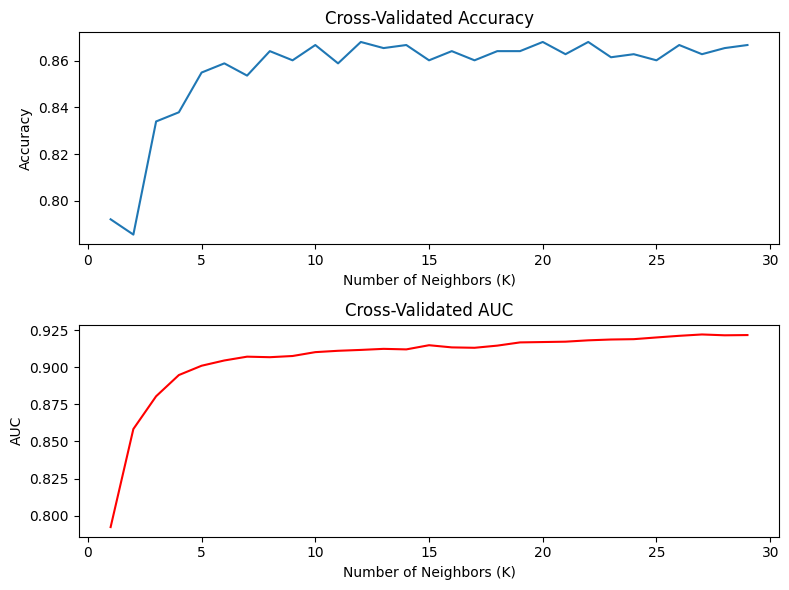

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

cv_scores_mean = []
auc_scores = []
neighbors_range = range(1, 30)

for n in neighbors_range:
    knn = KNeighborsClassifier(n_neighbors=n)

    # regular accuracy
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    cv_scores_mean.append(cv_scores.mean())

    # auc score
    y_scores = cross_val_predict(knn, X_train, y_train, cv=5, method="predict_proba")[
               :, 1
               ]
    auc_score = roc_auc_score(y_train, y_scores)
    auc_scores.append(auc_score)

optimal_n = neighbors_range[np.argmax(cv_scores_mean)]
optimal_n_auc = neighbors_range[np.argmax(auc_scores)]
print("The optimal number of neighbors is:", optimal_n)
print("The optimal number of neighbors based on AUC is:", optimal_n_auc)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

ax0.plot(neighbors_range, cv_scores_mean)
ax0.set_title("Cross-Validated Accuracy")
ax0.set_xlabel("Number of Neighbors (K)")
ax0.set_ylabel("Accuracy")

ax1.plot(neighbors_range, auc_scores, color="red")
ax1.set_title("Cross-Validated AUC")
ax1.set_xlabel("Number of Neighbors (K)")
ax1.set_ylabel("AUC")

plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.neighbors import KNeighborsClassifier


def get_result_stats(clf, X, y, pos_label="Kecimen"):
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)[:, 1]

    conf_matrix = confusion_matrix(y, y_pred, labels=["Kecimen", "Besni"])
    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    precision = precision_score(y, y_pred, pos_label=pos_label)
    recall = recall_score(y, y_pred, pos_label=pos_label)
    f1 = f1_score(y, y_pred, pos_label=pos_label)

    return y_pred, acc, auc_score, precision, recall, f1, conf_matrix


dtype = {
    "K": int,
    "Accuracy": float,
    "AUC": float,
    "Precision": float,
    "Recall": float,
    "F1 Score": float,
}
results_df = pd.DataFrame(
    columns=["K", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"]
).astype(dtype)

for val in [2, 12, 27, 28]:
    clf = KNeighborsClassifier(n_neighbors=val).fit(X_train, y_train)
    y_pred, acc, auc_score, precision, recall, f1, conf_matrix = get_result_stats(
        clf, X_test, y_test
    )

    df_conf_matrix = pd.DataFrame(
        conf_matrix,
        index=["Actual Kecimen", "Actual Besni"],
        columns=["Predicted Kecimen", "Predicted Besni"],
    )
    display(df_conf_matrix)

    df_conf_matrix.to_latex(
        f"./knn-cv-matrix-{val}.tex",
        caption=f"Sumaišymo matrica (n_neighbors = {val})",
        label=f"tab:knn-cv-conf-matrix-{val}",
        escape=True,
        bold_rows=True,
    )

    temp_df = pd.DataFrame(
        [[val, acc, auc_score, precision, recall, f1]],
        columns=["K", "Accuracy", "AUC", "Precision", "Recall", "F1 Score"],
    ).astype(dtype)
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df.to_latex(
    f"./knn-cv-scores.tex",
    index=False,
    float_format="%.3f",
    caption="Apskaičiuoti matai (Cross-Validation)",
    label="tab:knn-cv-scores",
    escape=True,
    bold_rows=True,
)

display(results_df)

,Predicted Kecimen,Predicted Besni
Actual Kecimen,44,28
Actual Besni,7,56


,Predicted Kecimen,Predicted Besni
Actual Kecimen,56,16
Actual Besni,9,54


,Predicted Kecimen,Predicted Besni
Actual Kecimen,58,14
Actual Besni,9,54


,Predicted Kecimen,Predicted Besni
Actual Kecimen,58,14
Actual Besni,9,54


,K,Accuracy,AUC,Precision,Recall,F1 Score
0,2,0.740741,0.833333,0.862745,0.611111,0.715447
1,12,0.814815,0.900353,0.861538,0.777778,0.817518
2,27,0.829630,0.915785,0.865672,0.805556,0.834532
3,28,0.829630,0.914021,0.865672,0.805556,0.834532


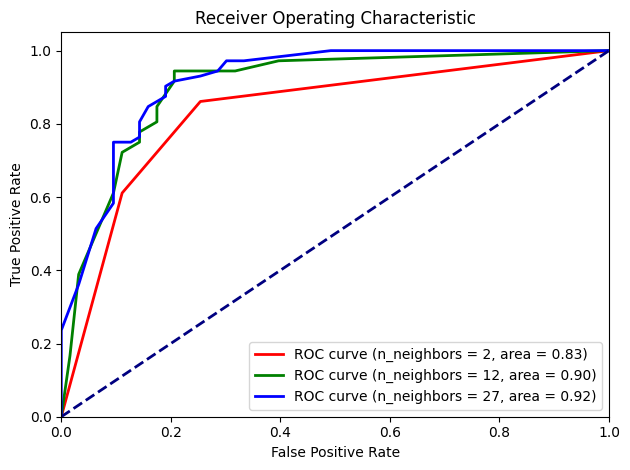

In [4]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

neighbors_values = [2, 12, 27]
colors = ["red", "green", "blue"]
plt.figure()

for n_neighbors, color in zip(neighbors_values, colors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)

    y_scores = knn.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_scores, pos_label="Kecimen")
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        color=color,
        lw=2,
        label="ROC curve (n_neighbors = %d, area = %0.2f)" % (n_neighbors, roc_auc),
    )

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()

plt.tight_layout()
plt.show()